# Fit a linear model on cell morphology features

Our aim is to determine which features significantly contribute to NF1 genotype adjusted by cell count

In [1]:
import pathlib
import pandas as pd

from sklearn.linear_model import LinearRegression

from pycytominer.cyto_utils import infer_cp_features

In [2]:
# Define inputs and outputs
data_dir = pathlib.Path("..", "..", "..", "4_processing_features", "data")
cp_file = pathlib.Path(data_dir, "nf1_sc_norm_cellprofiler.csv.gz")
dp_file = pathlib.Path(data_dir, "nf1_sc_norm_fs_deepprofiler_cyto.csv.gz")

output_dir = pathlib.Path("results")
output_cp_file = pathlib.Path(output_dir, "linear_model_cp_features.tsv")
output_dp_file = pathlib.Path(output_dir, "linear_model_dp_features.tsv")

## CellProfiler features

In [3]:
# Load data
cp_df = pd.read_csv(cp_file, index_col=0)

# Define CellProfiler features
cp_features = infer_cp_features(cp_df)

print(f"We are testing {len(cp_features)} CellProfiler features")
print(cp_df.shape)
cp_df.head()

We are testing 1043 CellProfiler features
(149, 1055)


,Metadata_WellRow,Metadata_WellCol,Metadata_number_of_singlecells,Metadata_gene_name,Metadata_genotype,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_OrigNuclei,...,Nuclei_Texture_SumVariance_RFP_3_02_256,Nuclei_Texture_SumVariance_RFP_3_03_256,Nuclei_Texture_Variance_GFP_3_00_256,Nuclei_Texture_Variance_GFP_3_01_256,Nuclei_Texture_Variance_GFP_3_02_256,Nuclei_Texture_Variance_GFP_3_03_256,Nuclei_Texture_Variance_RFP_3_00_256,Nuclei_Texture_Variance_RFP_3_01_256,Nuclei_Texture_Variance_RFP_3_02_256,Nuclei_Texture_Variance_RFP_3_03_256
0,C,6,12,NF1,WT,1,1,C6,1,4,...,3.141540,3.202273,-0.097356,-0.096165,-0.094202,-0.106456,3.337969,3.350528,3.278168,3.310371
1,C,6,12,NF1,WT,1,1,C6,2,5,...,0.315924,0.258633,-0.087971,-0.069493,-0.065539,-0.095377,0.314776,0.313920,0.348420,0.318693
2,C,6,12,NF1,WT,1,1,C6,3,7,...,0.295233,0.383161,0.065251,0.005550,-0.015212,-0.029087,0.348492,0.333940,0.341312,0.347999
3,C,6,12,NF1,WT,1,1,C6,4,8,...,1.151725,1.159965,0.023403,0.051931,0.026268,-0.002094,1.184695,1.243519,1.263751,1.167156
4,C,6,12,NF1,WT,4,1,C6,1,3,...,0.699723,0.628294,-0.428904,-0.416992,-0.429383,-0.420997,0.690298,0.662006,0.685883,0.701466


## Fit linear model

In [4]:
# Setup linear modeling framework
variables = ["Metadata_number_of_singlecells"]
X = cp_df.loc[:, variables]

# Add dummy matrix of categorical genotypes
genotype_x = pd.get_dummies(data=cp_df.Metadata_genotype)

X = pd.concat([X, genotype_x], axis=1)

print(X.shape)
X.head()

(149, 3)


,Metadata_number_of_singlecells,Null,WT
0,12,0,1
1,12,0,1
2,12,0,1
3,12,0,1
4,12,0,1


In [5]:
# Fit linear model for each feature
lm_results = []
for cp_feature in cp_features:
    # Subset CP data to each individual feature (univariate test)
    cp_subset_df = cp_df.loc[:, cp_feature]

    # Fit linear model
    lm = LinearRegression(fit_intercept=True)
    lm_result = lm.fit(X=X, y=cp_subset_df)
    
    # Extract Beta coefficients
    # (contribution of feature to X covariates)
    coef = lm_result.coef_
    
    # Estimate fit (R^2)
    r2_score = lm.score(X=X, y=cp_subset_df)
    
    # Add results to a growing list
    lm_results.append([cp_feature, r2_score] + list(coef))

# Convert results to a pandas DataFrame
lm_results = pd.DataFrame(
    lm_results,
    columns=["feature", "r2_score", "cell_count_coef", "Null_coef", "WT_coef"]
)

# Output file
lm_results.to_csv(output_cp_file, sep="\t", index=False)

print(lm_results.shape)
lm_results.head()

(1043, 5)


,feature,r2_score,cell_count_coef,Null_coef,WT_coef
0,Cytoplasm_Number_Object_Number,0.309209,0.033454,-0.012170,0.012170
1,Cytoplasm_AreaShape_Area,0.316175,-0.026661,-0.176198,0.176198
2,Cytoplasm_AreaShape_BoundingBoxArea,0.167982,-0.022169,-0.059594,0.059594
3,Cytoplasm_AreaShape_BoundingBoxMaximum_X,0.008340,0.002454,-0.139589,0.139589
4,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,0.001685,-0.003408,0.040239,-0.040239


/home/greg/miniconda3/envs/5.analyze_data_NF1/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='cell_count_coef', ylabel='WT_coef'>

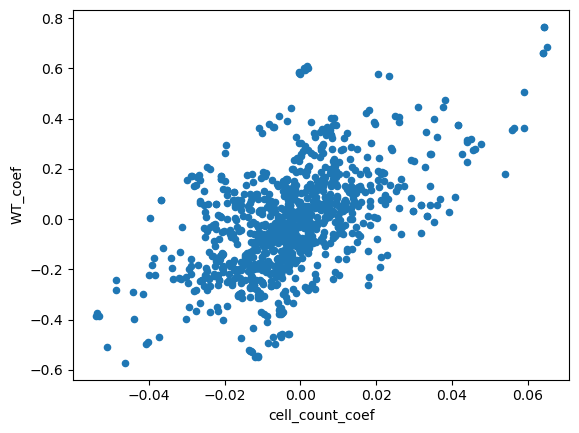

In [6]:
# Small exploration visualization
lm_results.plot(x="cell_count_coef", y="WT_coef", kind="scatter")

## DeepProfiler features

In [7]:
# Load data
dp_df = pd.read_csv(dp_file)

# Define CellProfiler features
dp_features = dp_df.columns[dp_df.columns.str.startswith("efficientnet")]

print(f"We are testing {len(dp_features)} DeepProfiler features")
print(dp_df.shape)
dp_df.head()

We are testing 3832 DeepProfiler features
(256, 3844)


,Location_Center_X,Location_Center_Y,Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Plate_Map_Name,Metadata_DNA,Metadata_ER,Metadata_Actin,Metadata_Genotype,...,efficientnet_3830,efficientnet_3831,efficientnet_3832,efficientnet_3833,efficientnet_3834,efficientnet_3835,efficientnet_3836,efficientnet_3837,efficientnet_3838,efficientnet_3839
0,650.422472,736.706742,1,D6,3,1_D6_3,../../../../1_preprocessing_data/Corrected_Ima...,../../../../1_preprocessing_data/Corrected_Ima...,../../../../1_preprocessing_data/Corrected_Ima...,WT,...,-0.034014,0.859518,-0.025713,-0.729571,0.267231,-0.847366,-1.090082,0.566786,-0.024363,0.230463
1,949.182667,256.734667,1,F6,2,1_F6_2,../../../../1_preprocessing_data/Corrected_Ima...,../../../../1_preprocessing_data/Corrected_Ima...,../../../../1_preprocessing_data/Corrected_Ima...,WT,...,-0.021109,0.185511,-0.612227,2.925806,-0.927761,-0.304350,-0.031065,0.626545,-0.408060,-1.211616
2,454.460081,265.797023,1,F6,2,1_F6_2,../../../../1_preprocessing_data/Corrected_Ima...,../../../../1_preprocessing_data/Corrected_Ima...,../../../../1_preprocessing_data/Corrected_Ima...,WT,...,-0.158382,-0.810211,-0.720877,0.127869,1.199453,1.977439,-0.844405,-0.299137,-0.775166,-0.292143
3,211.165254,274.745763,1,F6,2,1_F6_2,../../../../1_preprocessing_data/Corrected_Ima...,../../../../1_preprocessing_data/Corrected_Ima...,../../../../1_preprocessing_data/Corrected_Ima...,WT,...,-0.831178,-0.614643,-0.168719,-0.343051,-0.219525,0.493543,-0.751189,0.684554,0.159646,0.196000
4,375.125130,566.646507,1,F6,2,1_F6_2,../../../../1_preprocessing_data/Corrected_Ima...,../../../../1_preprocessing_data/Corrected_Ima...,../../../../1_preprocessing_data/Corrected_Ima...,WT,...,-0.118977,0.065025,-0.431710,-0.547652,-0.538548,0.022739,0.639954,0.393346,0.235406,0.932857


In [8]:
# Merge number of single cells per well data
cell_count_df = (
    dp_df
    .groupby("Metadata_Well")["Metadata_Plate"]
    .count()
    .reset_index()
    .rename(columns={"Metadata_Plate": "Metadata_number_of_singlecells"})
)

dp_df = dp_df.merge(cell_count_df, on="Metadata_Well")

In [9]:
# Setup linear modeling framework
variables = ["Metadata_number_of_singlecells"]
X = dp_df.loc[:, variables]

# Add dummy matrix of categorical genotypes
genotype_x = pd.get_dummies(data=dp_df.Metadata_Genotype)

X = pd.concat([X, genotype_x], axis=1)

print(X.shape)
X.head()

(256, 3)


,Metadata_number_of_singlecells,Null,WT
0,7,0,1
1,7,0,1
2,7,0,1
3,7,0,1
4,7,0,1


In [10]:
# Fit linear model for each feature
lm_results = []
for dp_feature in dp_features:
    # Subset DP data to each individual feature (univariate test)
    dp_subset_df = dp_df.loc[:, dp_feature]

    # Fit linear model
    lm = LinearRegression(fit_intercept=True)
    lm_result = lm.fit(X=X, y=dp_subset_df)
    
    # Extract Beta coefficients
    # (contribution of feature to X covariates)
    coef = lm_result.coef_
    
    # Estimate fit (R^2)
    r2_score = lm.score(X=X, y=dp_subset_df)
    
    # Add results to a growing list
    lm_results.append([dp_feature, r2_score] + list(coef))

# Convert results to a pandas DataFrame
lm_results = pd.DataFrame(
    lm_results,
    columns=["feature", "r2_score", "cell_count_coef", "Null_coef", "WT_coef"]
)

# Output file
lm_results.to_csv(output_dp_file, sep="\t", index=False)

print(lm_results.shape)
lm_results.head()

(3832, 5)


,feature,r2_score,cell_count_coef,Null_coef,WT_coef
0,efficientnet_0,0.046551,-0.013134,0.098892,-0.098892
1,efficientnet_1,0.026335,0.009009,-0.246789,0.246789
2,efficientnet_2,0.328083,-0.028034,0.001364,-0.001364
3,efficientnet_3,0.022191,0.005272,-0.223837,0.223837
4,efficientnet_4,0.010982,0.000086,-0.116931,0.116931


/home/greg/miniconda3/envs/5.analyze_data_NF1/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='cell_count_coef', ylabel='WT_coef'>

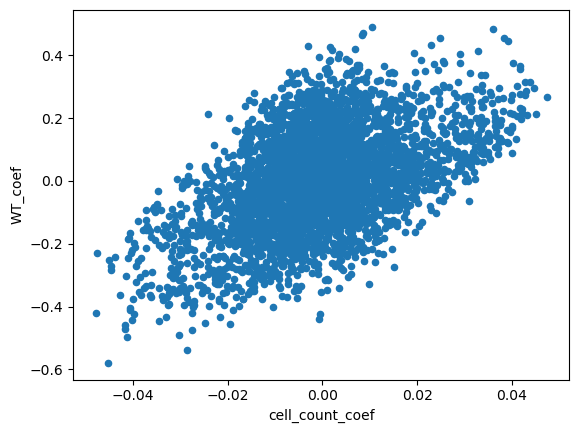

In [11]:
# Small exploration visualization
lm_results.plot(x="cell_count_coef", y="WT_coef", kind="scatter")